In [14]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split

In [15]:
# Importing training data

train_data1 = np.load('../DL-Project/data0.npy')
train_lab1 = np.load('../DL-Project/lab0.npy')

train_data2 = np.load('../DL-Project/data1.npy')
train_lab2 = np.load('../DL-Project/lab1.npy')

train_data3 = np.load('../DL-Project/data2.npy')
train_lab3 = np.load('../DL-Project/lab2.npy')


In [16]:
# Import images - load data into numpy arrays

images = np.concatenate((train_data1, train_data2, train_data3))
labels = np.concatenate((train_lab1, train_lab2, train_lab3))


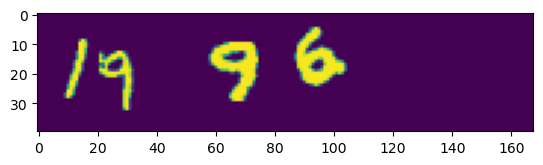

In [17]:
plt.imshow(images[0])

In [18]:
# Splitting the dataset into train, validate and test sets

train_images, temp_images, train_labels, temp_labels = train_test_split(
    images, labels, test_size=0.2, random_state=100
)
val_images, test_images, val_labels, test_labels = train_test_split(
    temp_images, temp_labels, test_size=0.5, random_state=100
)

In [19]:
# Converting the sets to pytorch compatible tensors

# train_images = torch.tensor(train_images, dtype=torch.float32)
# train_labels = torch.tensor(train_labels, dtype=torch.float32)
# val_images = torch.tensor(val_images, dtype=torch.float32)
# val_labels = torch.tensor(val_labels, dtype=torch.float32)
# test_images = torch.tensor(test_images, dtype=torch.float32)
# test_labels = torch.tensor(test_labels, dtype=torch.float32)

In [165]:
def connected_components_segmentation(image):
    """
    Segments digits using connected components labeling.

    Args:
        image (numpy array): Binary image with white digits on a black background.

    Returns:
        List[numpy array]: List of digit images extracted from connected components.
    """
    # Apply connected components labeling
    num_labels, labels = cv2.connectedComponents(image)

    # Extract each connected component as a separate digit
    digit_images = []
    for label in range(1, num_labels):  # Skip background label (0)
        component_mask = (labels == label).astype(np.uint8) * 255
        x, y, w, h = cv2.boundingRect(component_mask)  # Get bounding box
        digit_images.append(component_mask[y:y+h, x:x+w])  # Crop the digit

    return digit_images

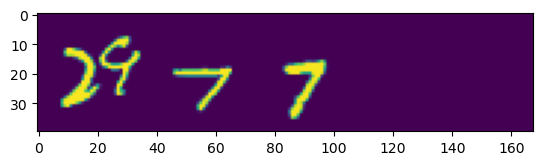

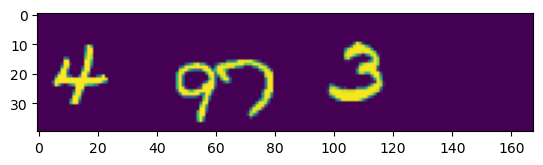

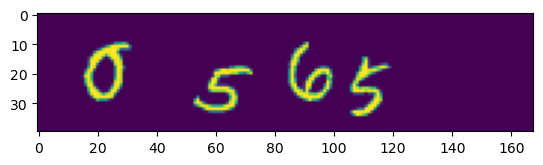

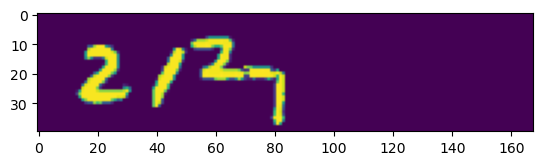

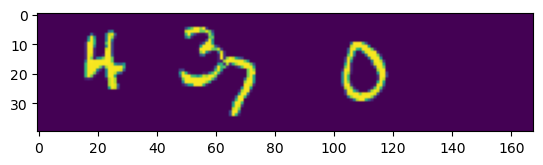

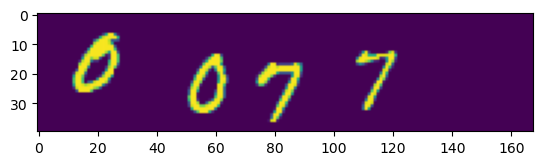

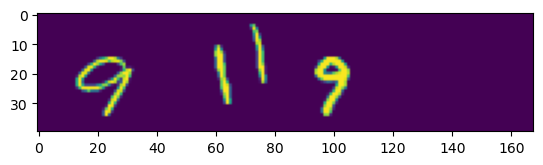

In [166]:
for i in range(3,10):
    plt.imshow(images[i])
    plt.show()

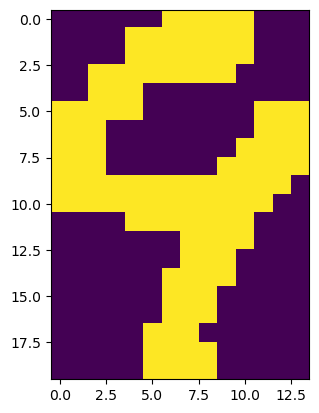

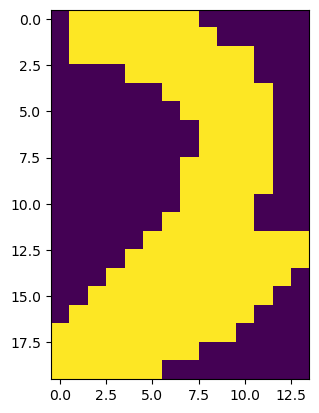

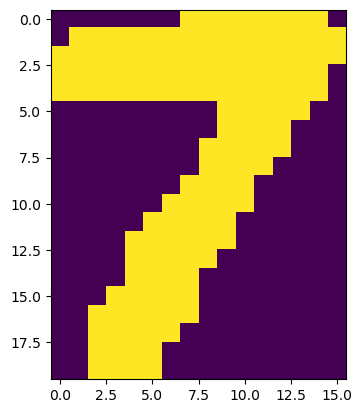

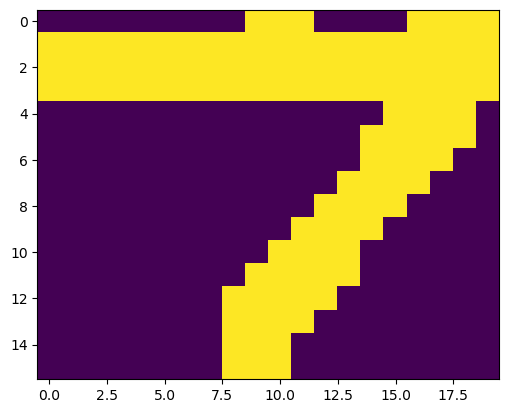

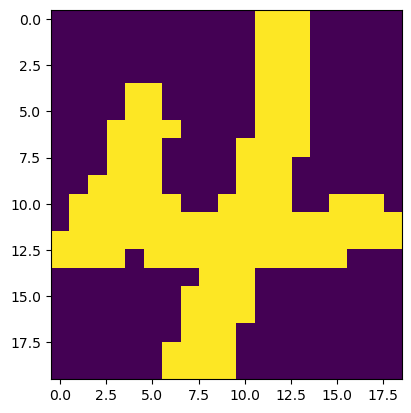

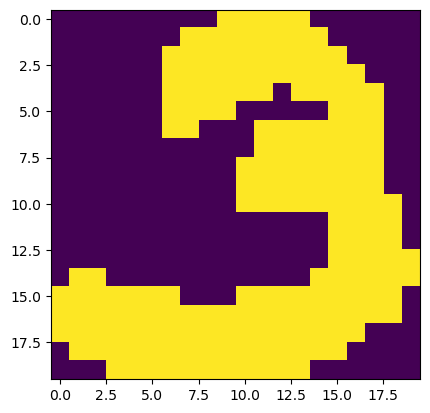

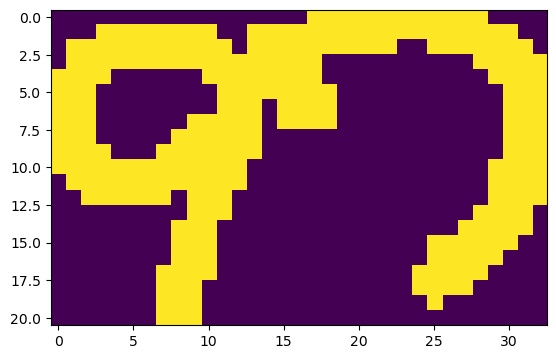

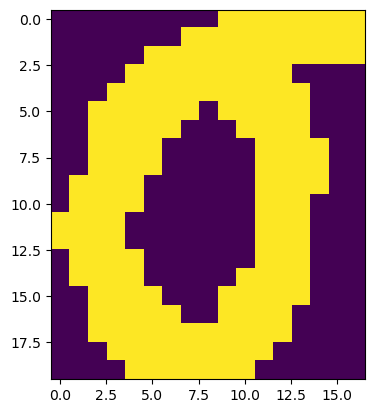

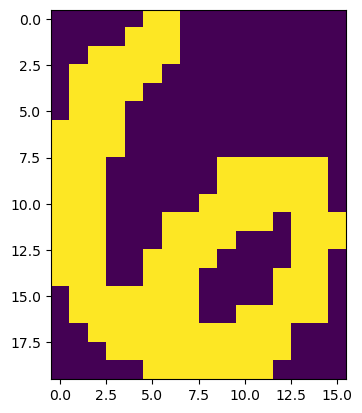

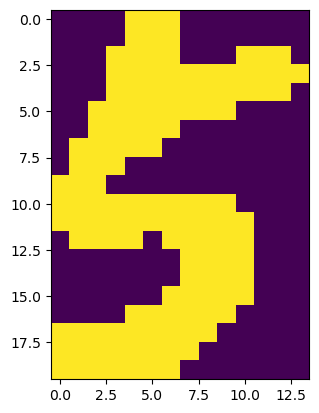

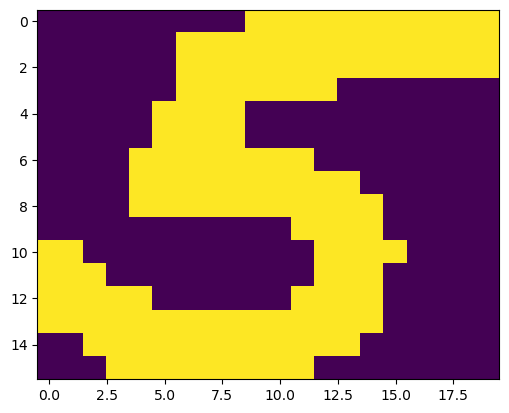

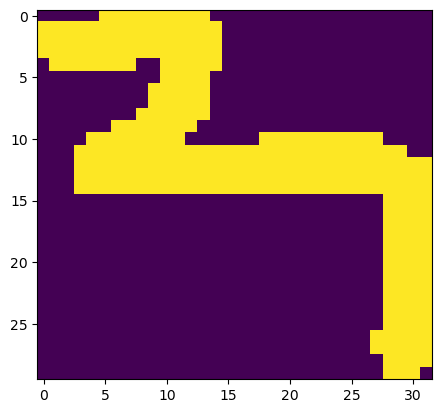

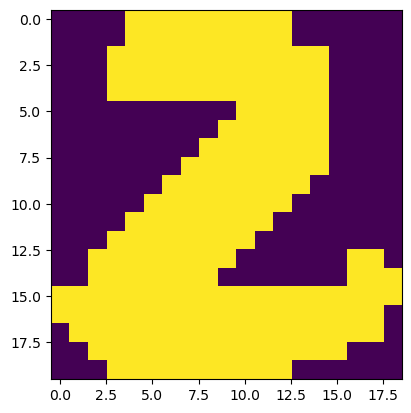

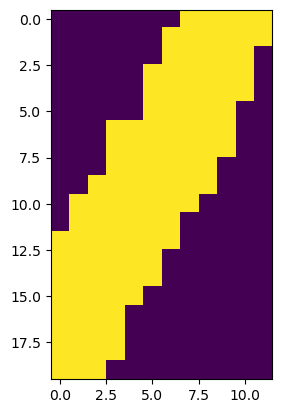

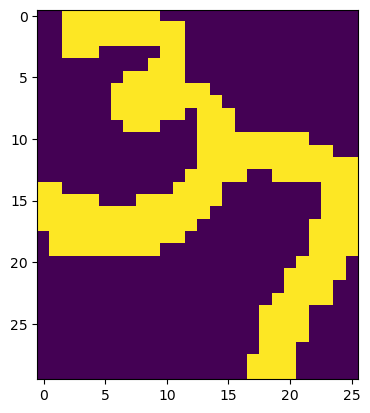

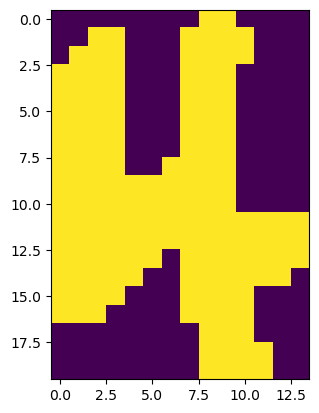

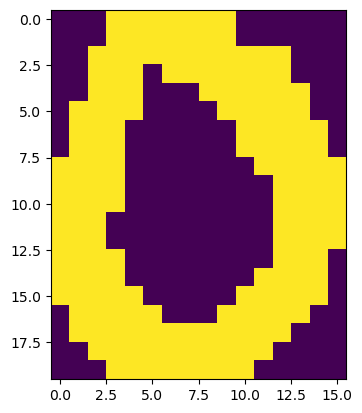

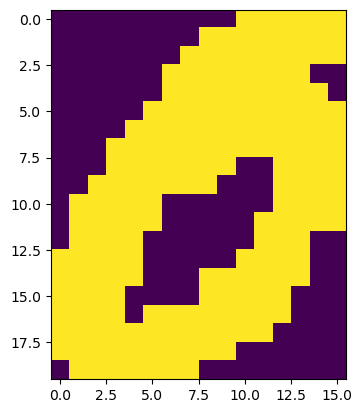

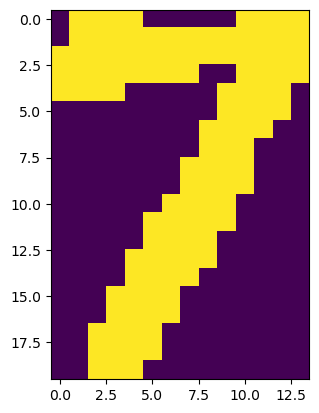

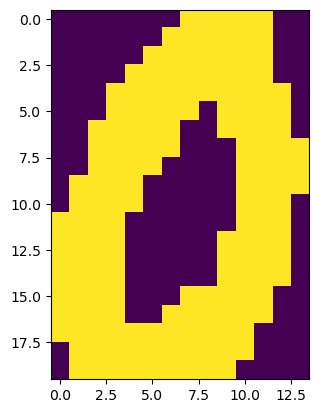

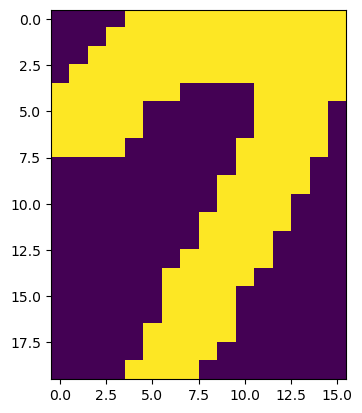

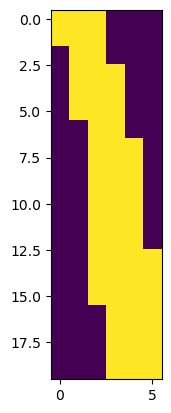

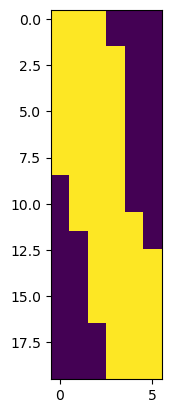

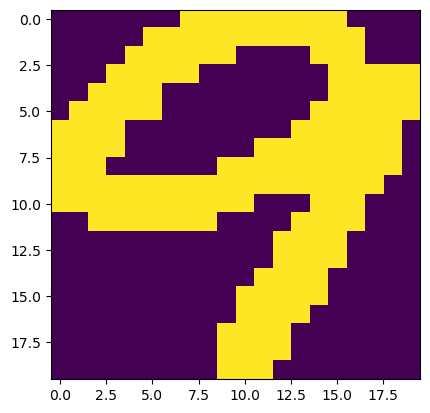

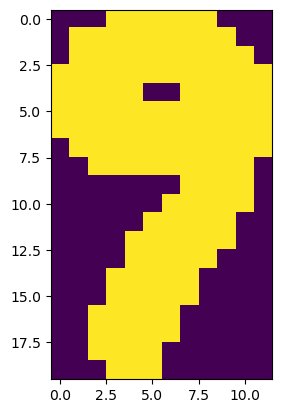

In [167]:
for i in range(3,10):
    for dig in connected_components_segmentation(images[i]):
        plt.imshow(dig)
        plt.show()

In [61]:
# PyTorch Transform to convert images to a set of 4 individual digits

class ExtractDigitsTransform:

    def __init__(self):
        self.resize_transform = transforms.Resize((28, 28))

    def __call__(self, image):
        """
        Args:
            image (PIL.Image or numpy array): Input image.

        Returns:
            List[torch.Tensor]: A list of 28x28 tensors representing the extracted digits.
        """

        # # Step 2: Convert to grayscale if it's not already
        # if len(image.shape) == 3 and image.shape[2] == 3:  # If image is RGB
        #     image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        kernel = np.ones((1,1),np.uint8)
        # erosion = cv2.erode(image,kernel,iterations = 2)
        erosion = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

        # Step 3: Apply binary thresholding
        _, binary = cv2.threshold(erosion, 127, 255, cv2.THRESH_BINARY)

        # return binary

        # Step 4: Find contours of the digits
        contours, _ = cv2.findContours(binary.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Step 5: Extract digits
        digit_tensors = []
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)

            # Ignore small or noisy regions
            if w > 5 and h > 5:
                digit = binary[y:y+h, x:x+w]  # Crop the digit
                target_size = 28
                height, width = h, w
                pad_top = (target_size - height) // 2
                pad_bottom = target_size - height - pad_top
                pad_left = (target_size - width) // 2
                pad_right = target_size - width - pad_left

                plt.imshow(binary)
                # print(pad_top, pad_bottom, pad_left, pad_right)
                # Step 3: Add padding using OpenCV (black pixels as padding)
                digit_resized = cv2.copyMakeBorder(
                    digit, 
                    pad_top, pad_bottom, pad_left, pad_right, 
                    borderType=cv2.BORDER_CONSTANT, value=0
                )
                # digit_resized = cv2.resize(digit, (28, 28), interpolation=cv2.INTER_AREA)  # Resize to 28x28

                # Convert to PyTorch Tensor (normalize to [0, 1])
                digit_tensor = torch.tensor(digit_resized, dtype=torch.float32).unsqueeze(0) / 255.0  # Add channel dim
                digit_tensors.append(digit_tensor[0])

        # Sort digits left-to-right based on x-coordinate
        # digit_tensors = sorted(digit_tensors, key=lambda t: cv2.boundingRect(contours[digit_tensors.index(t)])[0])

        return digit_tensors

In [62]:
digit_extraction_transform = ExtractDigitsTransform()

In [63]:
# Creating the Datasets from the tensors

class ImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        Args:
            image_dir (str): Directory containing the input images.
            transform (callable, optional): Transform to apply to the images.
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_array = self.images[idx]

        # Apply the transform (digit extraction)
        if self.transform:
            digits = self.transform(image_array)  # List of digit tensors
        else:
            digits = image_array

        return digits, self.labels[idx]


# train_dataset = ImageDataset(images, labels, transform=digit_extraction_transform)
train_dataset = ImageDataset(train_images, train_labels, transform=digit_extraction_transform)
val_dataset = ImageDataset(val_images, val_labels, transform=digit_extraction_transform)
test_dataset = ImageDataset(test_images, test_labels, transform=digit_extraction_transform)

# Creating DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

(4, 28, 28)


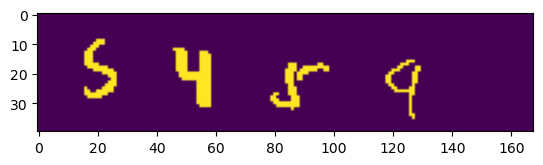

In [64]:
print(np.shape(train_dataset.__getitem__(1)[0]))

error: OpenCV(4.10.0) /usr/src/debug/opencv/opencv/modules/core/src/copy.cpp:1026: error: (-215:Assertion failed) top >= 0 && bottom >= 0 && left >= 0 && right >= 0 && _src.dims() <= 2 in function 'copyMakeBorder'


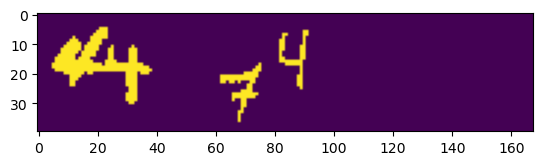

In [65]:
for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    labels = labels.unsqueeze(1)  # Match output shape
    print(np.shape(images[0]))
    # optimizer.zero_grad()
    # outputs = model(images)
    # loss = criterion(outputs, labels)
    # loss.backward()
    # optimizer.step()
    # train_loss += loss.item()

<Figure size 640x480 with 0 Axes>

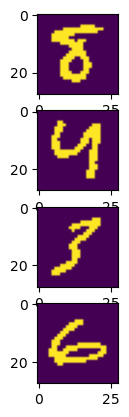

In [16]:
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(4,1) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(train_dataset.__getitem__(0)[0][0])
axarr[1].imshow(train_dataset.__getitem__(0)[0][1])
axarr[2].imshow(train_dataset.__getitem__(0)[0][2])
axarr[3].imshow(train_dataset.__getitem__(0)[0][3])

In [17]:
# Choosing GPU for training

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [18]:
# Defining the model and moving it to the gpu

class CNNRegressor(nn.Module):
    def __init__(self):
        super(CNNRegressor, self).__init__()
        self.conv_layers = nn.Sequential(
            # Convolution layer 1
            nn.Conv2d(4, 16, kernel_size=3, stride=1, padding=1),  # (N, 16, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (N, 16, 14, 14)
            # Convolution layer 2
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # (N, 32, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (N, 32, 7, 7)
            # Convolution layer 3
            # nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # (N, 32, 10, 42)
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2),  # (N, 32, 5, 21)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            # Fully connected layer 1
            nn.Linear(32 * 7 * 7, 256),
            nn.ReLU(),
            # Fully connected layer 1
            nn.Linear(256, 32),
            nn.ReLU(),
            # Fully connected layer 1
            nn.Linear(32, 4),
            nn.ReLU(),
            # Final layer for output
            nn.Linear(4, 1)  # Regression output
        )

    def forward(self, x):
        # Running the convolution layers
        x = self.conv_layers(x)
        # Running the fully connected layers
        x = self.fc_layers(x)
        return x

model = CNNRegressor().to(device)

In [19]:
# Defining Loss and Optimizer
criterion = nn.L1Loss() # L1 loss is the mean absolute error
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [20]:
# TQDM to keep track of the training
from tqdm import tqdm

In [21]:
# Defining the training Loop

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses = []
    validation_losses = []
    
    for epoch in tqdm(range(epochs)):
        
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.unsqueeze(1)  # Match output shape
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                labels = labels.unsqueeze(1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        train_losses.append(train_loss/len(train_loader))
        validation_losses.append(val_loss/len(val_loader))
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {validation_losses[-1]:.4f}")

    return (train_losses, validation_losses)


In [22]:
# Training the model for 40 epochs

train_losses, validation_losses = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=15)

  0%|                                                                                                                                                                                         | 0/15 [00:00<?, ?it/s]


error: OpenCV(4.10.0) /usr/src/debug/opencv/opencv/modules/core/src/copy.cpp:1026: error: (-215:Assertion failed) top >= 0 && bottom >= 0 && left >= 0 && right >= 0 && _src.dims() <= 2 in function 'copyMakeBorder'


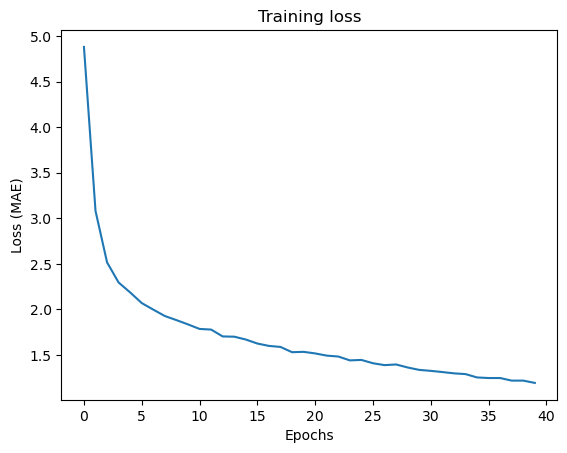

In [14]:
plt.plot(train_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss (MAE)")
plt.title("Training loss")
plt.show()

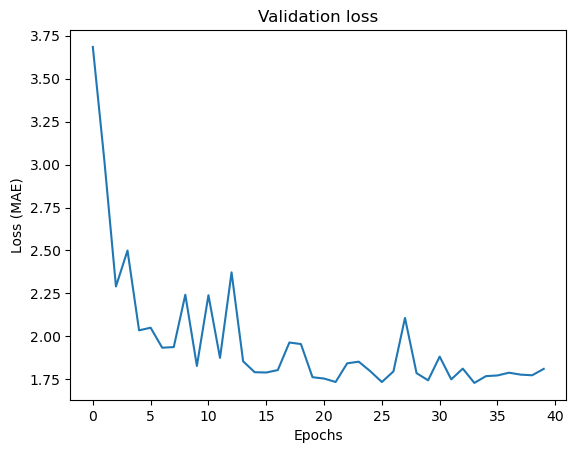

In [15]:
plt.plot(validation_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss (MAE)")
plt.title("Validation loss")
plt.show()

In [16]:
# Save the model

torch.save(model.state_dict(), "model.pth")

In [17]:
# Testing the Model on the test dataset

def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
    print(f"Test Loss: {test_loss/len(test_loader):.4f}")
    return [labels, outputs]

l,o = evaluate_model(model, test_loader)


Test Loss: 1.7951


In [18]:
# A set of the predicted values for comparison

print("Actual\t:\tPredicted\t:\tDiffrence")
for el in range(len(l)):
    print(float(l[el][0]), "\t:\t", float(o[el][0]), "\t:\t", float(o[el][0] - l[el][0]))

Actual	:	Predicted	:	Diffrence
13.0 	:	 12.023143768310547 	:	 -0.9768562316894531
8.0 	:	 7.0523881912231445 	:	 -0.9476118087768555
22.0 	:	 23.7950496673584 	:	 1.7950496673583984
11.0 	:	 10.127303123474121 	:	 -0.8726968765258789
15.0 	:	 14.909523963928223 	:	 -0.09047603607177734
19.0 	:	 19.951597213745117 	:	 0.9515972137451172
18.0 	:	 18.037399291992188 	:	 0.0373992919921875
15.0 	:	 15.052903175354004 	:	 0.052903175354003906
14.0 	:	 15.035238265991211 	:	 1.035238265991211
28.0 	:	 30.039779663085938 	:	 2.0397796630859375
12.0 	:	 12.84731388092041 	:	 0.8473138809204102
16.0 	:	 16.27943229675293 	:	 0.2794322967529297
23.0 	:	 21.265348434448242 	:	 -1.7346515655517578
23.0 	:	 24.823923110961914 	:	 1.823923110961914
15.0 	:	 16.493295669555664 	:	 1.493295669555664
17.0 	:	 16.891489028930664 	:	 -0.10851097106933594
12.0 	:	 14.995077133178711 	:	 2.995077133178711
30.0 	:	 30.147348403930664 	:	 0.14734840393066406
15.0 	:	 16.670658111572266 	:	 1.670658111572265

In [ ]:
# Defining the Classification model, loading it and moving it to the gpu

class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNRegressor, self).__init__()
        self.conv_layers = nn.Sequential(
            # Convolution layer 1
            nn.Conv2d(1, 10, kernel_size=28, stride=1, padding=14),  # (N, 10, 40, 168)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (N, 10, 20, 84)
            # Convolution layer 2
            nn.Conv2d(10, 16, kernel_size=3, stride=1, padding=1),  # (N, 16, 20, 84)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (N, 16, 10, 42)
            # Convolution layer 3
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # (N, 32, 10, 42)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (N, 32, 5, 21)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            # Fully connected layer 1
            nn.Linear(32 * 5 * 21, 256),
            nn.ReLU(),
            # Fully connected layer 2
            nn.Linear(256, 40),
        )

    def forward(self, x):
        # Running the convolution layers
        x = self.conv_layers(x)
        # Running the fully connected layers
        x = self.fc_layers(x)
        return x

model = CNNClassifier().to(device)
model.load_state_dict(torch.load('model.pth', weights_only=True))